#  Data-driven analytics using Airbnb Seattle open data

by Vincent Gacutan

- **LinkedIn**: https://www.linkedin.com/in/vincentgacutan/
- **Medium**: https://vmgacutan.medium.com/where-to-stay-in-seattle-wa-32c6434b4198

I'm familiar with Seattle area and I'd like to confirm my thoughts using Seattle Airbnb actvity open data and uncover these questions:
  1.  What is the busiest time of the year to visit Seattle?
  2.  What are the rental properties available in the area?
  3.  Is there a price seasonality of rental properties?
  4.  How does price seasonality affect property types and room types?
  5.  What is the vibe of the neighborhood in Seattle?

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile as zp
import seaborn as sns
import nltk  
from nltk.tokenize import regexp_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 
from collections import Counter
%matplotlib inline

nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/VMG/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Curate the Dataset

  `listings.csv` - This includes full host property descriptions, price and review score.
  
  `reviews.csv` - This includes unique id for each reviewer and detailed comments.
  
  `calendar.csv` - This includes listing id and price availability for that day.

In [23]:
z1 = zp.ZipFile('./calendar.zip')
z2 = zp.ZipFile('./reviews.zip')

df = pd.read_csv('./listings.csv')
df1 = pd.read_csv(z1.open('calendar.csv'))
df2 = pd.read_csv(z2.open('reviews.csv'))

print('Listing dataset has {} number of rows and {} number of columns'.format(df.shape[0],df.shape[1]))
print('Review dataset has {} number of rows and {} number of columns'.format(df1.shape[0],df1.shape[1]))
print('Calendar dataset has {} number of rows and {} number of columns'.format(df2.shape[0],df2.shape[1]))

Listing dataset has 3818 number of rows and 92 number of columns
Review dataset has 1393570 number of rows and 4 number of columns
Calendar dataset has 84849 number of rows and 6 number of columns


In [24]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [4]:
print('Listing:',df.columns[df.isnull().sum() == 0],'\n')
print('Count of Columns with NO NULL values:',len(df.columns[df.isnull().sum() == 0]),'\n')
print(df.columns[df.isnull().sum() > 0],'\n')
print('Count of Columns with NULL values:',len(df.columns[df.isnull().sum() > 0]))

Listing: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'experiences_offered', 'picture_url', 'host_id', 'host_url',
       'host_verifications', 'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'room_type', 'accommodates', 'bed_type',
       'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count'],
      dtype='object') 

Count of Columns with NO NULL values: 47 

In [5]:
print('Reviews:',df1.columns[df1.isnull().sum() == 0],'\n')
print('Count of Columns with NO NULL values:',len(df1.columns[df1.isnull().sum() == 0]),'\n')
print(df2.columns[df2.isnull().sum() > 0],'\n')
print('Count of Columns with NULL values:',len(df1.columns[df1.isnull().sum() > 0]))

Reviews: Index(['listing_id', 'date', 'available'], dtype='object') 

Count of Columns with NO NULL values: 3 

Index(['comments'], dtype='object') 

Count of Columns with NULL values: 1


In [6]:
print('Calendar:',df2.columns[df2.isnull().sum() == 0],'\n')
print('Count of Columns with NO NULL values:',len(df2.columns[df2.isnull().sum() == 0]),'\n')
print(df2.columns[df2.isnull().sum() > 0],'\n')
print('Count of Columns with NULL values:',len(df2.columns[df2.isnull().sum() > 0]))

Calendar: Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name'], dtype='object') 

Count of Columns with NO NULL values: 5 

Index(['comments'], dtype='object') 

Count of Columns with NULL values: 1


## 1.   What is the busiest time of the year to visit Seattle?
Note: `calendar.csv` `'date'` column is an object, so it needs to be converted to `datetime`.

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [9]:
df2['date'] = pd.to_datetime(df2['date'])

In [10]:
df2.insert(2,'month',pd.DatetimeIndex(df2['date']).month)
df2.insert(2,'year',pd.DatetimeIndex(df2['date']).year)

df2['Month_Name'] = df2['date'].dt.strftime('%b')
df2.head(5)

,listing_id,id,year,month,date,reviewer_id,reviewer_name,comments,Month_Name
0,7202016,38917982,2015,7,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Jul
1,7202016,39087409,2015,7,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Jul
2,7202016,39820030,2015,7,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",Jul
3,7202016,40813543,2015,8,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,Aug
4,7202016,41986501,2015,8,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,Aug


In [11]:
visitor_df = df2.groupby(['year', 'month','Month_Name']).size().reset_index()
visitor_df.columns= ['year','month','month_','guest_count']
visitor_df.sort_values(['year','month'], ascending =[1,1])

,year,month,month_,guest_count
0,2009,6,Jun,2
1,2009,7,Jul,1
2,2009,8,Aug,1
3,2009,9,Sep,2
4,2009,10,Oct,6
...,...,...,...,...
74,2015,9,Sep,6985
75,2015,10,Oct,5536
76,2015,11,Nov,3998
77,2015,12,Dec,3351


In [12]:
#finding the percent changes of guest per year
v_df=visitor_df.copy()
print(v_df.groupby(['year']).sum()['guest_count'],'\n')
print(v_df.groupby(['year',]).sum()['guest_count'].pct_change())

year
2009       17
2010      254
2011     1169
2012     3251
2013     7077
2014    20365
2015    52493
2016      223
Name: guest_count, dtype: int64 

year
2009          NaN
2010    13.941176
2011     3.602362
2012     1.781009
2013     1.176869
2014     1.877632
2015     1.577609
2016    -0.995752
Name: guest_count, dtype: float64


Every year starting from 2013, guest grew around 1.5%. Guests  starting to pick up around Spring and peak season starts Summer, high on August and guests starting to disperse around late Summer and early Fall (last week of August to early September).


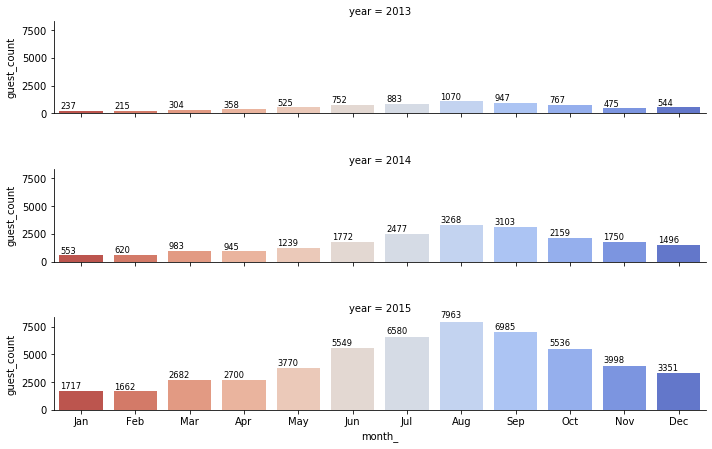

In [13]:
v=sns.catplot(x="month_", y="guest_count", row="year", palette ="coolwarm_r",
                kind="bar", height=2.5, aspect=4,
                data=visitor_df.query("year == 2015 or year == 2014 or year == 2013"))#titanic.query,query("fare > 0")
plt.subplots_adjust(hspace = 0.6, top = 0.8)
#g1.fig.subplots_adjust(top=.8)
v.set_titles( col_template = '{col_name}')

for i in [0,1, 2]:
    ax = v.facet_axis(i,0)
    for p in ax.patches:     
        ax.text(p.get_x() + 0.015, 
        p.get_height() * 1.02, 
        '{0:.0f}'.format(p.get_height()), 
        color='black', rotation='horizontal', size='small', va = 'bottom')

print('Every year starting from 2013, guest grew around 1.5%. Guests  starting to pick up around Spring and peak season starts Summer, high on August and guests starting to disperse around late Summer and early Fall (last week of August to early September).')

## 2.  What are the rental properties available in the area?

In [14]:
prop_type = df.dropna(subset=['property_type'], axis =0)
prop_type=prop_type.groupby(['property_type']).count()['id']/prop_type.shape[0]*100#.reset_index()
prop_type=prop_type.sort_values(ascending = False).reset_index()
prop_type.rename(columns={'index': 'property_type', 'id': 'pct(%)'}, inplace=True)
prop_type

,property_type,pct(%)
0,House,45.402148
1,Apartment,44.747184
2,Townhouse,3.091433
3,Condominium,2.384071
4,Loft,1.047943
5,Bed & Breakfast,0.969348
6,Other,0.576369
7,Cabin,0.550170
8,Camper/RV,0.340582
9,Bungalow,0.340582


Most popular properties are House and Apartment covering 45% and 44% respectively


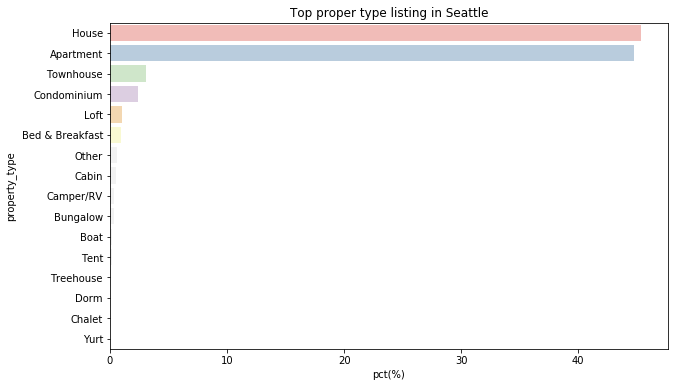

In [15]:
custom_palette = {'House':'#FBB4AE',
                  'Apartment':'#B3CDE3',
                  'Townhouse':'#CCEBC5',
                  'Condominium':'#DECBE4',
                  'Loft':'#FED9A6',
                  'Bed & Breakfast':'#FFFFCC',
                  'Other':'#F2F2F2',
                  'Cabin':'#F2F2F2',
                  'Camper/RV':'#F2F2F2',
                  'Bungalow':'#F2F2F2',
                  'Boat':'#F2F2F2',
                  'Tent':'#F2F2F2',
                  'Treehouse':'#F2F2F2',
                  'Dorm':'#F2F2F2',
                  'Chalet':'#F2F2F2',
                  'Yurt':'#F2F2F2'}

plt.figure (figsize=(10,6)) 
#sns.barplot(y='property_type',x='pct%', data=prop_type, palette = "PRGn_r") #PRGn_r
sns.barplot(y='property_type',x='pct(%)', data=prop_type, palette =custom_palette)#palette = "PRGn_r") #PRGn_r
plt.title('Top proper type listing in Seattle');

print('Most popular properties are House and Apartment covering 45% and 44% respectively')

## 3.  Is there a price seasonality of rental properties?
 #### Combining two files together
Merging both `listing.csv` and `calendar.csv`.

 #### Converting data types object to float
Column values containing `'$'` dollar amount like `'price', 'weekly_price'`..etc are all data type objects.  Converting to float will allow us to do statistical analysis on the prices.

In [16]:
#filtering only the properties that are available in the calendar file
calendar_df = df1[df1['available']=='t']

In [17]:
#combining bothe calendar and listing file
merge1_df =pd.merge(calendar_df, df, how='inner', left_on=['listing_id'], right_on=['id'])
merge1_df.head(5)

,listing_id,date,available,price_x,id,listing_url,scrape_id,last_scraped,name,summary,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,241032,2016-01-05,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,241032,2016-01-13,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
3,241032,2016-01-14,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
4,241032,2016-01-18,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [18]:
#converting date object to datetime
merge1_df['date'] = pd.to_datetime(merge1_df['date'])

merge1_df.rename(columns={'price_x': 'price_'}, inplace = True)

In [19]:
#converting 'price' columns to 'float'
merge1_df['price_'] = merge1_df['price_'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [20]:
#adding month, year and month name
merge1_df.insert(2,'month',pd.DatetimeIndex(merge1_df['date']).month)
merge1_df.insert(2,'year',pd.DatetimeIndex(merge1_df['date']).year)
#df2['Month_Name'] = df2['date'].dt.strftime('%b')
merge1_df.insert(2,'month_',merge1_df['date'].dt.strftime('%b'))
merge1_df.head(5)

,listing_id,date,month_,year,month,available,price_,id,listing_url,scrape_id,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,Jan,2016,1,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,241032,2016-01-05,Jan,2016,1,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,241032,2016-01-13,Jan,2016,1,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
3,241032,2016-01-14,Jan,2016,1,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
4,241032,2016-01-18,Jan,2016,1,t,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [21]:
merge1_df = merge1_df.dropna(subset=['property_type'], axis =0)
merge1_df['property_type'].isnull().sum()

0

In [22]:
price_avg_df = merge1_df.groupby(['year', 'month','month_']).mean()['price_'].reset_index()
price_avg_df.head()

,year,month,month_,price_
0,2016,1,Jan,121.568409
1,2016,2,Feb,124.293985
2,2016,3,Mar,128.647681
3,2016,4,Apr,135.102964
4,2016,5,May,139.545759


Average prices of rental properties starts to pick up in Spring and peak season starts in Summer.  Its when the availability of rental properties are limited driving the prices up. 



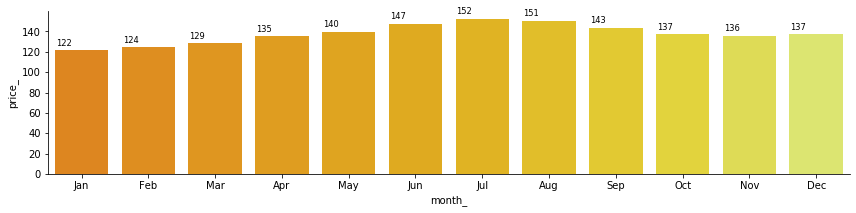

In [23]:
v1=sns.catplot(x="month_", y='price_',palette = ("Wistia_r"),#row="year",
               kind="bar",
               height=3, aspect=4,
                data=price_avg_df.query("year == 2016"))

ax = v1.facet_axis(0,0)
for p in ax.patches: 
    
        ax.text(p.get_x() + 0.015, 
        p.get_height() * 1.02, 
        '{0:.0f}'.format(p.get_height()), 
        color='black', rotation='horizontal', size='small', va = 'bottom') 

print('Average prices of rental properties starts to pick up in Spring and peak season starts in Summer.  Its when the availability of rental properties are limited driving the prices up.','\n')
    

In [24]:
pr=['House','Apartment','Townhouse','Condominium','Loft','Bed & Breakfast']

propType_group = merge1_df[merge1_df['year'] ==2016]
propType_group=propType_group.groupby(['property_type','room_type',]).mean()['price_'].reset_index()
propType_group = propType_group[propType_group['property_type'].isin(pr)]
propType_group.head()

,property_type,room_type,price_
0,Apartment,Entire home/apt,151.912239
1,Apartment,Private room,83.778632
2,Apartment,Shared room,56.500041
3,Bed & Breakfast,Entire home/apt,103.914518
4,Bed & Breakfast,Private room,120.413864


Shows the average price of property against the room type. Townhouse tend to be the priciest when renting the "Entire home" and can be as low as around $50 compared to a "Shared room". Surprisingly, renting an entire House can be a little cheaper than Townhouse because in my opinion, the Host can factor in Homeowner Association Dues (HOA) in the price which tend to be more higher than HOA dues for a House. 



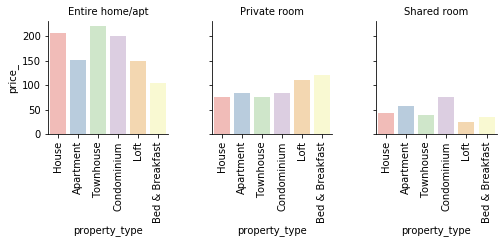

In [58]:
f23 = sns.FacetGrid(propType_group, col="room_type", col_wrap=3, height = 2.5)
f23.map(sns.barplot, "property_type", "price_", palette=custom_palette, ci=None, order = pr)
f23.set_xticklabels(rotation=90)
f23.set_titles(row_template = '{row_name}', col_template = '{col_name}');

print('Shows the average price of property against the room type. Townhouse tend to be the priciest when renting the "Entire home" and can be as low as around $50 compared to a "Shared room". Surprisingly, renting an entire House can be a little cheaper than Townhouse because in my opinion, the Host can factor in Homeowner Association Dues (HOA) in the price which tend to be more higher than HOA dues for a House.', '\n')

## 4.  How does price seasonality affect property types and room types?

In [26]:
propprice_avg_df = merge1_df.groupby(['year', 'month','month_','property_type','room_type']).mean()['price_'].reset_index()

In [27]:
propprice_avg_df = propprice_avg_df[propprice_avg_df['year'] ==2016]

propprice_avg_df = propprice_avg_df[propprice_avg_df['property_type'].isin(pr)]
propprice_avg_df

,year,month,month_,property_type,room_type,price_
0,2016,1,Jan,Apartment,Entire home/apt,132.800883
1,2016,1,Jan,Apartment,Private room,79.868366
2,2016,1,Jan,Apartment,Shared room,57.024444
3,2016,1,Jan,Bed & Breakfast,Entire home/apt,97.222222
4,2016,1,Jan,Bed & Breakfast,Private room,110.946143
...,...,...,...,...,...,...
412,2016,12,Dec,Loft,Private room,106.732719
413,2016,12,Dec,Loft,Shared room,25.000000
419,2016,12,Dec,Townhouse,Entire home/apt,224.943089
420,2016,12,Dec,Townhouse,Private room,83.006093


Average price trends of property type and room type for Y2016 (numbers on the x-axis represents the month). The top 3 property (House, Apartment, Townhouse) are the drivers of price seasonality as evident in Figure 4 specially when guest rented the entire home. But the "Shared room" doesnt seem to have price seasonality across different property types. 



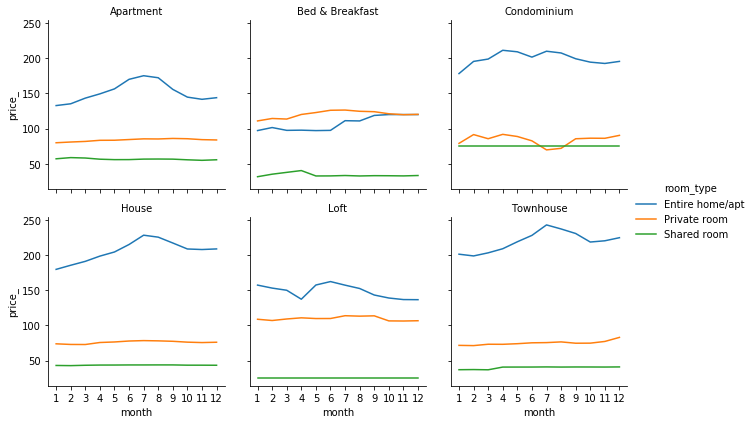

In [28]:
t1=sns.FacetGrid(propprice_avg_df, col="property_type", hue = "room_type", col_wrap=3)
t1.map(sns.lineplot,"month", "price_", sort=True)#size_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) #, ci=None, linestyles = '-.')
t1.set(xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
t1.add_legend()
t1. set_titles(row_template = '{row_name}', col_template = '{col_name}');

print('Average price trends of property type and room type for Y2016 (numbers on the x-axis represents the month). The top 3 property (House, Apartment, Townhouse) are the drivers of price seasonality as evident in Figure 4 specially when guest rented the entire home. But the "Shared room" doesnt seem to have price seasonality across different property types.','\n')


## 5.  What is the vibe of the neighborhood in Seattle?
Describing the vibe of each Seattle neighborhood using listing descriptions.  I'm assuming here that the host property description and guest comments would provide some context of the neighborhood vibe.

I use `NLTK sentiment analysis` to extract the words and gain some context behind the property description and comments. 

In [29]:
#snapshot of one of the host property description
nb_desc_df = df[['neighbourhood_group_cleansed','property_type','description']]
nb_desc_df  = nb_desc_df.dropna(subset=['property_type'], axis=0)
nb_desc_df.isnull().sum()

txt_HostDescription = (nb_desc_df['description'][2])
txt_HostDescription

'New modern house built in 2013.  Spectacular sunset/water views and light, rooftop deck and lounge area, hot tub, 5 bedrooms, gourmet kitchen.  Perfect for 2-3 families, walk to downtown.  Located in highly desirable Queen Anne neighborhood. Our house is modern, light and fresh with a warm simple palette accented with barnwood, steel and concrete.  Open living spaces for entertaining, gourmet kitchen, deck off the kitchen, reading nook, half bath and smaller tv room off kitchen.  Fireplace with sofa and sitting area. Basement room is great for kids...this room has patio access and a garage door that opens into the space with basketball hoop right outside.  A queen bedroom and full bath are in the basement with concrete heated floors.  A queen sleeper sofa is in the tv area in the basement.  This room has a door if privacy is needed.  Great for a second family with kids.  The 2nd floor has 4 bedrooms (one queen in master, one twin bedroom, another bedroom has twin bunk beds and the las

In [30]:
# 17  neighbourhood groups in Seattle including 'Other neighborhoods'.  We are omiting 'Other neighborhoods' in the analysis
# which makes up only 16 neighbourhood groups.

neighbourhood_list = list(nb_desc_df['neighbourhood_group_cleansed'].unique())
neighbourhood_list

['Queen Anne',
 'Ballard',
 'Other neighborhoods',
 'Cascade',
 'Central Area',
 'University District',
 'Downtown',
 'Magnolia',
 'West Seattle',
 'Interbay',
 'Beacon Hill',
 'Rainier Valley',
 'Delridge',
 'Seward Park',
 'Northgate',
 'Capitol Hill',
 'Lake City']

### Combining both `listing` and `reviews` dataset.
Combining both files, we can identify the guest comments on each listed property and neighborhood groups where the property belowng to.

In [31]:
review_dropna = df2.dropna(subset =['comments'], axis=0)

merge_review_df =pd.merge(review_dropna, df, how='inner', left_on=['listing_id'], right_on=['id'])

In [32]:
# Here is a snapshot of the guest comment
reviews = merge_review_df[['listing_id','date','neighbourhood_group_cleansed','comments']]

txt_GuestDescription = reviews[reviews['listing_id'] ==3544550].reset_index()
txt_GuestDescription = txt_GuestDescription['comments'][0]
txt_GuestDescription

"Staying in Jill's home was a great experience. The house is absolutely beautiful, there was plenty of room for my 8 person group, and she even left us wine and chocolate to make us feel welcome. Queen Anne is a beautiful neighborhood and we really got to experience some of the best views in the city both from the home and the neighborhood. Thank you so much Jill!"

### Sentiment Analysis
I'm simplying sentiment analysis using `VADER (Valence Aware Dictionary and sEntiment Reasoner)`. `VADER` is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

`VADER` algorithm produces sentiment scores to 4 classes: `POSITIVE`, `NEGATIVE`, `NEUTRAL`, `COMPOUND`.  This analysis only focuses on both `POSITIVE` and `NEGATIVE` sentiment.



In [33]:
# Here is snapshot of the Host property description classifying it to 3 sentiments

check_wrd = Counter()
list_wrd = []

pos_word =[]
neg_word =[]
nuet_word =[]

wrd = regexp_tokenize(str(txt_HostDescription).lower(), pattern = "\w+")
filtered_wrd = [w for w in wrd if not w in stop_words]

for word in filtered_wrd:
    check_wrd[word] += 1
    if word not in list_wrd:
        list_wrd.append(word)
    
for word in list_wrd:
    if (sia.polarity_scores(word)['compound']) >= 0.5:
        pos_word.append(word)
    elif (sia.polarity_scores(word)['compound']) <= -0.5:
        neg_word.append(word)
    else:
        nuet_word.append(word)
            
print('POSITIVE:', pos_word,'\n')
print('NEGATIVE:', neg_word,'\n')
print('NEUTRAL:', nuet_word,'\n')


POSTIVE: ['perfect', 'great'] 

NEGATIVE: [] 

NEUTRAL: ['new', 'modern', 'house', 'built', '2013', 'spectacular', 'sunset', 'water', 'views', 'light', 'rooftop', 'deck', 'lounge', 'area', 'hot', 'tub', '5', 'bedrooms', 'gourmet', 'kitchen', '2', '3', 'families', 'walk', 'downtown', 'located', 'highly', 'desirable', 'queen', 'anne', 'neighborhood', 'fresh', 'warm', 'simple', 'palette', 'accented', 'barnwood', 'steel', 'concrete', 'open', 'living', 'spaces', 'entertaining', 'reading', 'nook', 'half', 'bath', 'smaller', 'tv', 'room', 'fireplace', 'sofa', 'sitting', 'basement', 'kids', 'patio', 'access', 'garage', 'door', 'opens', 'space', 'basketball', 'hoop', 'right', 'outside', 'bedroom', 'full', 'heated', 'floors', 'sleeper', 'privacy', 'needed', 'second', 'family', '2nd', 'floor', '4', 'one', 'master', 'twin', 'another', 'bunk', 'beds', 'last'] 



In [34]:
# Here is snapshot of the Guest comments classifying it to 3 sentiments

check_wrd = Counter()
list_wrd = []

pos_word =[]
neg_word =[]
nuet_word =[]

wrd = regexp_tokenize(str(txt_GuestDescription).lower(), pattern = "\w+")
filtered_wrd = [w for w in wrd if not w in stop_words]

for word in filtered_wrd:
    check_wrd[word] += 1
    if word not in list_wrd:
        list_wrd.append(word)
    
for word in list_wrd:
    if (sia.polarity_scores(word)['compound']) >= 0.5:
        pos_word.append(word)
    elif (sia.polarity_scores(word)['compound']) <= -0.5:
        neg_word.append(word)
    else:
        nuet_word.append(word)
            
print('POSTIVE:', pos_word,'\n')
print('NEGATIVE:', neg_word,'\n')
print('NEUTRAL:', nuet_word,'\n')

POSTIVE: ['great', 'beautiful', 'best'] 

NEGATIVE: [] 

NEUTRAL: ['staying', 'jill', 'home', 'experience', 'house', 'absolutely', 'plenty', 'room', '8', 'person', 'group', 'even', 'left', 'us', 'wine', 'chocolate', 'make', 'feel', 'welcome', 'queen', 'anne', 'neighborhood', 'really', 'got', 'views', 'city', 'thank', 'much'] 



In [35]:
def positive_word(df, nb, top = 10):
    
    '''
    INPUT 
        df - listing data frame containing both 'neighbourhood_group_cleansed','description' columns
        nb - neighborhood group name
        top - top number of words to include
      
    
    OUTPUT
        positive_word_dict - unique list of POSITIVE words derived from all the property description within the neighborhood groups.
    '''
    if type(nb) != str:
        return -1
    
    nb_desc_df = df[['neighbourhood_group_cleansed','description']]
    nb_desc_df_drop_na = nb_desc_df.dropna()
    nb_list=list(nb_desc_df_drop_na['neighbourhood_group_cleansed'])
    nb_description=list(nb_desc_df_drop_na['description'])
    
    word_list=[]
    word_counter = Counter()
    
    positive_word = []
    negative_word = []
    neutral_word = []
    
    for i in range(len(nb_description)):
        if (nb_list[i]== str(nb)):
            wrd = regexp_tokenize(nb_description[i].lower(), pattern = "\w+")
            filtered_sentence = [w for w in wrd if not w in stop_words]
            
            for word in filtered_sentence:
                word_counter[word] += 1
                if word not in word_list:
                    word_list.append(word)
    
    for word in word_list:
        if (sia.polarity_scores(word)['compound']) >= 0.5:
            positive_word.append(word)
        elif (sia.polarity_scores(word)['compound']) <= -0.5:
            negative_word.append(word)
        else:
            neutral_word.append(word)
    
    positive_word_dict = {}
    positive_word_dict_nb ={}
    
    for i in positive_word:
          positive_word_dict[i] = int(word_counter[i])
    
    sorted_words = sorted(positive_word_dict.items(), key=lambda x: x[1], reverse = True)
    positive_word_dict_nb[nb] = dict(sorted_words[:top])

    return positive_word_dict_nb

In [36]:
def positive_word_review(df, nb, top = 10):
    
    '''
    INPUT 
        df - dataframe containing guests commentts
        nb - neighborhood group name
        top - top number of words to include
      
    
    OUTPUT
        positive_word_dict - unique list of POSITVE words derived from all the property guest reviews within the neighborhood groups.
    '''
    if type(nb) != str:
        return -1
    
    nb_desc_df = df[['neighbourhood_group_cleansed','comments']]
    nb_desc_df_drop_na = nb_desc_df.dropna()
    nb_list=list(nb_desc_df_drop_na['neighbourhood_group_cleansed'])
    nb_description=list(nb_desc_df_drop_na['comments'])
    
    word_list=[]
    word_counter = Counter()
    
    positive_word = []
    negative_word = []
    neutral_word = []
    
    for i in range(len(nb_description)):
        if (nb_list[i]== str(nb)):
            wrd = regexp_tokenize(nb_description[i].lower(), pattern = "\w+")
            filtered_sentence = [w for w in wrd if not w in stop_words]
            
            for word in filtered_sentence:
                word_counter[word] += 1
                if word not in word_list:
                    word_list.append(word)
    
    for word in word_list:
        if (sia.polarity_scores(word)['compound']) >= 0.5:
            positive_word.append(word)
        elif (sia.polarity_scores(word)['compound']) <= -0.5:
            negative_word.append(word)
        else:
            neutral_word.append(word)
    
    positive_word_dict = {}
    positive_word_dict_nb ={}
    
    for i in positive_word:
          positive_word_dict[i] = int(word_counter[i])
    
    sorted_words = sorted(positive_word_dict.items(), key=lambda x: x[1], reverse = True)
    positive_word_dict_nb[nb] = dict(sorted_words[:top])

    return positive_word_dict_nb

In [37]:
def negative_word_review(df, nb, top = 10):
    
    '''
    INPUT 
        df - dataframe containing guests commnets
        nb - neighborhood group name
        top - top number of words to include
      
    
    OUTPUT
        positive_word_dict - unique list of NEGATIVE words derived from all the property guest reviews  within the neighborhood groups.
    '''
    if type(nb) != str:
        return -1
    
    nb_desc_df = df[['neighbourhood_group_cleansed','comments']]
    nb_desc_df_drop_na = nb_desc_df.dropna()
    nb_list=list(nb_desc_df_drop_na['neighbourhood_group_cleansed'])
    nb_description=list(nb_desc_df_drop_na['comments'])
    
    word_list=[]
    word_counter = Counter()
    
    positive_word = []
    negative_word = []
    neutral_word = []
    
    for i in range(len(nb_description)):
        if (nb_list[i]== str(nb)):
            wrd = regexp_tokenize(nb_description[i].lower(), pattern = "\w+")
            filtered_sentence = [w for w in wrd if not w in stop_words]
            
            for word in filtered_sentence:
                word_counter[word] += 1
                if word not in word_list:
                    word_list.append(word)
    
    for word in word_list:
        if (sia.polarity_scores(word)['compound']) >= 0.5:
            positive_word.append(word)
        elif (sia.polarity_scores(word)['compound']) <= -0.5:
            negative_word.append(word)
        else:
            neutral_word.append(word)
    
    negative_word_dict = {}
    negative_word_dict_nb ={}
    
    for i in negative_word:
          negative_word_dict[i] = int(word_counter[i])
    
    sorted_words = sorted(negative_word_dict.items(), key=lambda x: x[1], reverse = True)
    negative_word_dict_nb[nb] = dict(sorted_words[:top])

    return negative_word_dict_nb

In [38]:
# Top 10 Positive sentiments coming from the host property description within each neighborhood groups
nbr_merge={}
nbr_name = []
wrd_cnts = []

for i in neighbourhood_list:
    nbr_merge.update(positive_word(df, i,top=10))

for k, v in nbr_merge.items():
    nbr_name.append(k)
    wrd_cnts.append(pd.DataFrame.from_dict(v, orient='index'))

merge_vibe= pd.concat(wrd_cnts, keys=nbr_name).reset_index()
merge_vibe.columns= ['neighborhood','host_vibe_words','word_counts']

merge_vibe.style.bar(subset=['word_counts'], color='#5fba7d')

,neighborhood,host_vibe_words,word_counts
0,Queen Anne,great,144
1,Queen Anne,beautiful,101
2,Queen Anne,free,92
3,Queen Anne,comfortable,70
4,Queen Anne,best,52
5,Queen Anne,love,43
6,Queen Anne,amazing,41
7,Queen Anne,perfect,39
8,Queen Anne,charming,34
9,Queen Anne,lovely,29


In [39]:
comments_merge={}
nbr_name_review = []
wrd_cnts_review = []

for i in neighbourhood_list:
    comments_merge.update(positive_word_review(merge_review_df, i,top=10))

for k, v in comments_merge.items():
    nbr_name_review.append(k)
    wrd_cnts_review.append(pd.DataFrame.from_dict(v, orient='index'))
    
merge_guest_commnets= pd.concat(wrd_cnts_review, keys=nbr_name_review).reset_index()
merge_guest_commnets.columns= ['neighborhood_group','guest_positive_reviews','word_counts_1']

In [40]:
#  Table shows top 10 positive sentiments comparison between host property description and guest comments

result = pd.concat([merge_vibe, merge_guest_commnets], axis=1)

result_df = result[['neighborhood','host_vibe_words','word_counts','guest_positive_reviews','word_counts_1']]
result_df.rename(columns={'word_counts': 'host_wrd_cnt', 'word_counts_1': 'guest_wrd_cnt'}, inplace=True)

result_df.style.bar(subset=['host_wrd_cnt','guest_wrd_cnt'], color='#5fba7d')

/Users/VMG/opt/anaconda3/envs/p36workshop/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,neighborhood,host_vibe_words,host_wrd_cnt,guest_positive_reviews,guest_wrd_cnt
0,Queen Anne,great,144,great,5022
1,Queen Anne,beautiful,101,comfortable,2035
2,Queen Anne,free,92,perfect,1423
3,Queen Anne,comfortable,70,wonderful,1146
4,Queen Anne,best,52,beautiful,1022
5,Queen Anne,love,43,lovely,837
6,Queen Anne,amazing,41,loved,752
7,Queen Anne,perfect,39,enjoyed,744
8,Queen Anne,charming,34,amazing,647
9,Queen Anne,lovely,29,super,647


In [41]:
negative_comments={}
nbr_neg_review = []
neg_cnts_review = []

for i in neighbourhood_list:
    negative_comments.update(negative_word_review(merge_review_df, i,top=3))

for k, v in negative_comments.items():
    nbr_neg_review.append(k)
    neg_cnts_review.append(pd.DataFrame.from_dict(v, orient='index'))

In [42]:
# Table shows top 3 negative sentiments from the guest comments within each property groups 

neg_guest_comments= pd.concat(neg_cnts_review, keys=nbr_neg_review).reset_index()
neg_guest_comments.columns= ['neighborhood_group','guest_negative_reviews','guest_negative_words']
neg_guest_comments.head(10)

,neighborhood_group,guest_negative_reviews,guest_negative_words
0,Queen Anne,bad,47
1,Queen Anne,die,45
2,Queen Anne,war,16
3,Ballard,rob,101
4,Ballard,bad,36
5,Ballard,die,22
6,Other neighborhoods,bad,116
7,Other neighborhoods,die,77
8,Other neighborhoods,negative,51
9,Cascade,bad,12


#### Combining all the sentiments into neighborhood groups 

In [43]:
def highlight_greater(x):
    r = '#31a354'
    g = 'gray'

    #m1 = x['B'] > x['C']
    #m2 = x['D'] > x['E']
    m1 = x['HOST_positive_words'] ==  x['GUEST_positive_words']
    #m2 = x['guest_positive_reviews'] ==  x['host_vibe_words']
    

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['HOST_positive_words'] = np.where(m1, 'background-color: {}'.format(r), df1['HOST_positive_words'])
    df1['GUEST_positive_words'] = np.where(m1, 'background-color: {}'.format(r), df1['GUEST_positive_words'])
    return df1

In [44]:
# Table shows all the sentiments from Host property description and guest comments. 
result_all = pd.concat([merge_vibe, merge_guest_commnets, neg_guest_comments], axis=1)

result_all = result_all[['neighborhood','host_vibe_words','word_counts','guest_positive_reviews','word_counts_1','guest_negative_reviews', 'guest_negative_words']]
result_all.rename(columns={'word_counts': 'host_wrd_cnt', 'word_counts_1': 'guest_wrd_cnt','guest_negative_words': 'guest_neg_wrd_cnt'}, inplace=True)
result_all

,neighborhood,host_vibe_words,host_wrd_cnt,guest_positive_reviews,guest_wrd_cnt,guest_negative_reviews,guest_neg_wrd_cnt
0,Queen Anne,great,144,great,5022,bad,47.0
1,Queen Anne,beautiful,101,comfortable,2035,die,45.0
2,Queen Anne,free,92,perfect,1423,war,16.0
3,Queen Anne,comfortable,70,wonderful,1146,rob,101.0
4,Queen Anne,best,52,beautiful,1022,bad,36.0
...,...,...,...,...,...,...,...
165,Lake City,great,8,beautiful,133,NaN,NaN
166,Lake City,best,6,lovely,124,NaN,NaN
167,Lake City,happy,5,loved,92,NaN,NaN
168,Lake City,charming,5,kind,75,NaN,NaN


In [45]:
name = list(result_all['neighborhood'])
data_frame = []
for i in name:
    x=result_all[result_all['neighborhood'] == i].head(1)
    data_frame.append(x)
data_frame = pd.concat(data_frame)

In [59]:
distinct_vibe =data_frame.groupby(['neighborhood','host_vibe_words','guest_positive_reviews']).size().reset_index()
distinct_vibe=distinct_vibe[['neighborhood','host_vibe_words','guest_positive_reviews']]
distinct_vibe.columns = ['NEIGHBORHOOD','HOST_positive_words', 'GUEST_positive_words']
#distinct_vibe.style.hide_index()

print('The table represent the top positive word thats coming out from the host property description and guest comment that stayed on the same property.','\n')
distinct_vibe.style.apply(highlight_greater, axis=None).hide_index()

The table represent the top positive word thats coming out from the host property description and guest comment that stayed on the same property. 



NEIGHBORHOOD,HOST_positive_words,GUEST_positive_words
Ballard,great,great
Beacon Hill,great,great
Capitol Hill,great,great
Cascade,great,great
Central Area,great,great
Delridge,free,great
Downtown,great,great
Interbay,great,great
Lake City,comfortable,great
Magnolia,great,great


In [47]:
y = merge_guest_commnets.copy()
y.insert(2,'vibe','positive')
y.rename(columns={'neighborhood_group': 'neighborhood', 'guest_positive_reviews': 'words','word_counts_1': 'word_count'}, inplace=True)

In [48]:
z = neg_guest_comments.copy()
z.insert(2,'vibe','negative')
z.rename(columns={'neighborhood_group': 'neighborhood', 'guest_negative_reviews': 'words','guest_negative_words': 'word_count'}, inplace=True)

In [49]:
#joining both guest positive and negative words
vibe_all = pd.concat([y,z])

In [50]:
vibe_group=vibe_all.groupby(['neighborhood','words','vibe']).sum()['word_count'].reset_index()
vibe_group= vibe_group.sort_values(['neighborhood','word_count'], ascending =[1,0]).reset_index(drop = True)

In [51]:
d =dict(vibe_group.groupby(['neighborhood']).sum()['word_count'])
d    

{'Ballard': 15053,
 'Beacon Hill': 5752,
 'Capitol Hill': 24319,
 'Cascade': 2886,
 'Central Area': 16612,
 'Delridge': 4105,
 'Downtown': 23718,
 'Interbay': 253,
 'Lake City': 1827,
 'Magnolia': 1814,
 'Northgate': 2619,
 'Other neighborhoods': 35259,
 'Queen Anne': 14383,
 'Rainier Valley': 7735,
 'Seward Park': 2304,
 'University District': 1999,
 'West Seattle': 7235}

In [52]:
# Adding total word count to the dataframe

nb_group = vibe_group.groupby(['neighborhood']).agg({'word_count': 'sum'})

vibe_group =pd.merge(vibe_group, nb_group, how='inner', left_on=['neighborhood'], right_on=['neighborhood'])

# Adding percentage count of words
vibe_group['pct'] = np.round(((vibe_group['word_count_x']/vibe_group['word_count_y'])*100),2)

# converting negative word count to negative so it will be more visible to visulize using charts
vibe_group.loc[vibe_group['vibe']=='negative', ['pct']] *= -1.0

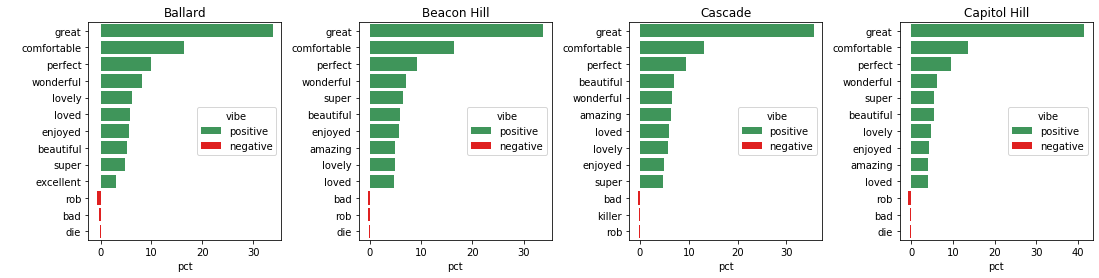

In [53]:
# visualizing first 4 neighborhood groups.  Top 10 positve words againts top 3 negative words  

nbs = ['Ballard', 'Beacon Hill','Cascade','Capitol Hill']
colours = {"positive": "#31a354", "negative": "red"}
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(wspace=.4)

sns.barplot(ax=axes[0], data=vibe_group[vibe_group['neighborhood'].isin([nbs[0]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[0].set(ylabel = " ",title = '{0}'.format(nbs[0]))
sns.barplot(ax=axes[1], data=vibe_group[vibe_group['neighborhood'].isin([nbs[1]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[1].set(ylabel = " ",title = '{0}'.format(nbs[1]))
sns.barplot(ax=axes[2], data=vibe_group[vibe_group['neighborhood'].isin([nbs[2]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[2].set(ylabel = " ",title = '{0}'.format(nbs[2]))
sns.barplot(ax=axes[3], data=vibe_group[vibe_group['neighborhood'].isin([nbs[3]])], x='pct', y='words', hue = 'vibe', palette = colours, dodge=False)
axes[3].set(ylabel = " ",title = '{0}'.format(nbs[3]));


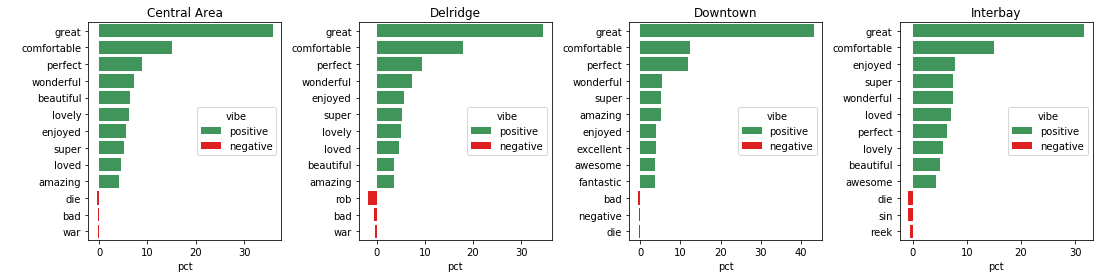

In [54]:
# visualizing first 2nd 4 neighborhood groups.  Top 10 positve words againts top 3 negative words  

nbs = ['Central Area','Delridge','Downtown','Interbay']
colours = {"positive": "#31a354", "negative": "red"}
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(wspace=.4)

sns.barplot(ax=axes[0], data=vibe_group[vibe_group['neighborhood'].isin([nbs[0]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[0].set(ylabel = " ",title = '{0}'.format(nbs[0]))
sns.barplot(ax=axes[1], data=vibe_group[vibe_group['neighborhood'].isin([nbs[1]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[1].set(ylabel = " ",title = '{0}'.format(nbs[1]))
sns.barplot(ax=axes[2], data=vibe_group[vibe_group['neighborhood'].isin([nbs[2]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[2].set(ylabel = " ",title = '{0}'.format(nbs[2]))
sns.barplot(ax=axes[3], data=vibe_group[vibe_group['neighborhood'].isin([nbs[3]])], x='pct', y='words', hue = 'vibe', palette = colours, dodge=False)
axes[3].set(ylabel = " ",title = '{0}'.format(nbs[3]));


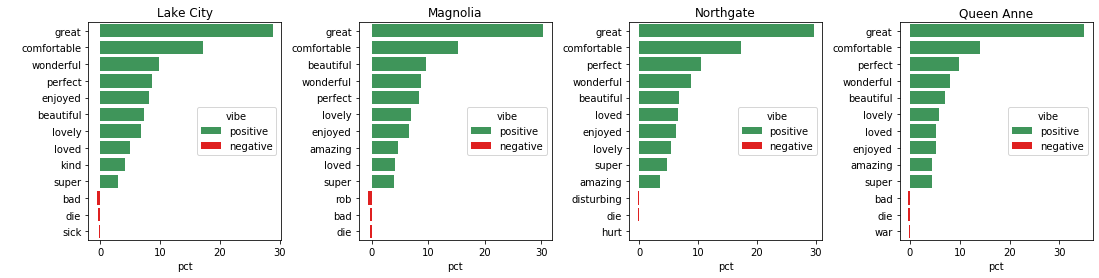

In [55]:
# visualizing 3rd 4 neighborhood groups.  Top 10 positve words againts top 3 negative words  

nbs = ['Lake City','Magnolia','Northgate','Queen Anne']
colours = {"positive": "#31a354", "negative": "red"}
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(wspace=.4)

sns.barplot(ax=axes[0], data=vibe_group[vibe_group['neighborhood'].isin([nbs[0]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[0].set(ylabel = " ",title = '{0}'.format(nbs[0]))
sns.barplot(ax=axes[1], data=vibe_group[vibe_group['neighborhood'].isin([nbs[1]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[1].set(ylabel = " ",title = '{0}'.format(nbs[1]))
sns.barplot(ax=axes[2], data=vibe_group[vibe_group['neighborhood'].isin([nbs[2]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[2].set(ylabel = " ",title = '{0}'.format(nbs[2]))
sns.barplot(ax=axes[3], data=vibe_group[vibe_group['neighborhood'].isin([nbs[3]])], x='pct', y='words', hue = 'vibe', palette = colours, dodge=False)
axes[3].set(ylabel = " ",title = '{0}'.format(nbs[3]));


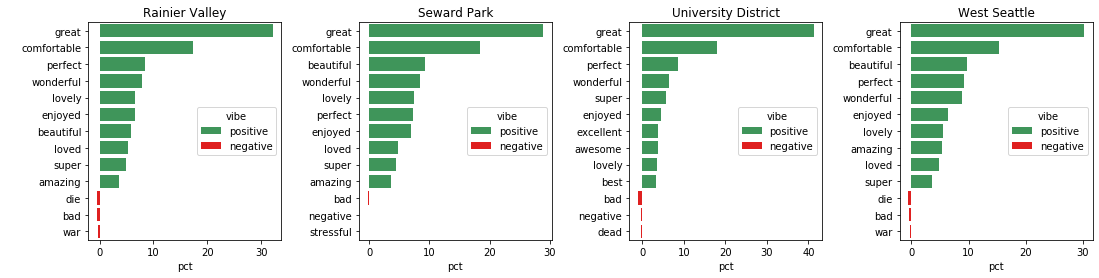

In [56]:
# visualizing last 4 neighborhood groups.  Top 10 positve words againts top 3 negative words

nbs = ['Rainier Valley',
 'Seward Park',
 'University District',
 'West Seattle']
colours = {"positive": "#31a354", "negative": "red"}
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(wspace=.4)

sns.barplot(ax=axes[0], data=vibe_group[vibe_group['neighborhood'].isin([nbs[0]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[0].set(ylabel = " ",title = '{0}'.format(nbs[0]))
sns.barplot(ax=axes[1], data=vibe_group[vibe_group['neighborhood'].isin([nbs[1]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[1].set(ylabel = " ",title = '{0}'.format(nbs[1]))
sns.barplot(ax=axes[2], data=vibe_group[vibe_group['neighborhood'].isin([nbs[2]])], x='pct', y='words', hue = 'vibe',palette = colours, dodge=False)
axes[2].set(ylabel = " ",title = '{0}'.format(nbs[2]))
sns.barplot(ax=axes[3], data=vibe_group[vibe_group['neighborhood'].isin([nbs[3]])], x='pct', y='words', hue = 'vibe', palette = colours, dodge=False)
axes[3].set(ylabel = " ",title = '{0}'.format(nbs[3]));


#### Combining all the charts together
In Seattle, there are 16 of neighborhoods groups to choose from as listed in the Airbnb dataset. Each of these neighborhood has different vibe that suite guest personalities, but the top 3 most common sentiments on each neighborhood show are `great`, `comfortable` and `perfect` covering around 50% of positive words. The top 3 negative sentiments are very low that only constitute lower that 5% of the words. Other positive words that are evident are `beautiful`, `wonderful`, `lovely`, and `amazing`.

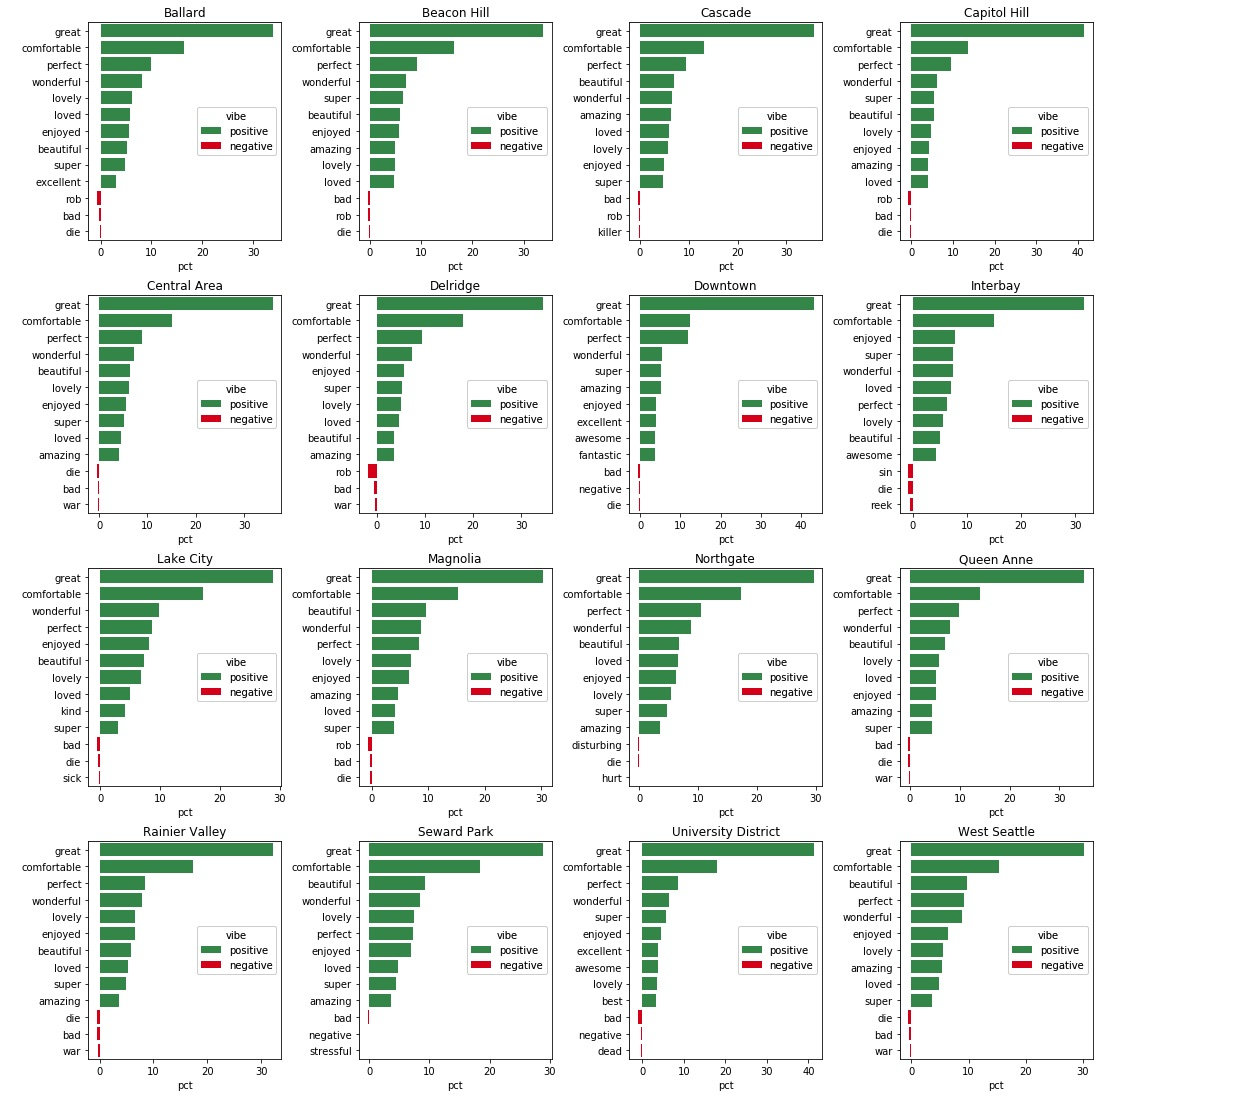

In [57]:
from IPython.display import Image
Image(filename='neighborhood_vibe_chart.png')